In [32]:
import numpy as np 
import geopandas as gpd 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import pandas as pd 
from shapely.geometry import shape 
# from shapely.geometry import Polygon 
import json 
from shapely import wkt 
from shapely.geometry import Point
from shapely.geometry import box
from math import cos, radians
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
import seaborn as sns 
import contextily as ctx
import xarray as xr

In [33]:
# !pip install censusdata

In [34]:
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import censusdata

## Social Vulnerability Index 

* CDC/ATSDR Social Vulnerability Index
* The degree to which a community exhibits certain social conditions, including high poverty, low percentage of vehicle access, or
crowded households, among others 

#### 4 Themes 
* Socioeconomic Status - RPL_THEME1
* Household Characteristics - RPL_THEME2
* Racial & Ethnic Minority Status - RPL_THEME3
* Housing Type & Transportation - RPL_THEME4 

#### Overall Vulnerability Ranking available as well 
* overall summary ranking variable is RPL_THEMES 

#### The higher the value, the greater the vulnerability 

Documentation can be found here: https://svi.cdc.gov/map25/data/docs/SVI2022Documentation_ZCTA.pdf

In [170]:
svi_cali_census_tracts_fp = 'California_SVI_Census_Tracts.csv'

In [171]:
svi_cali_census_tracts_df = pd.read_csv(svi_cali_census_tracts_fp)

### Filter out LA County & relevant columns (population, 4 SVI themes, population) 

In [172]:
la_svi_census_df = svi_cali_census_tracts_df[svi_cali_census_tracts_df['COUNTY'] == 'Los Angeles County'].reset_index()

In [173]:
# la_svi_census_df.columns.tolist()

In [174]:
la_svi_census_df = la_svi_census_df[['COUNTY', 'FIPS', 'LOCATION', 'AREA_SQMI','E_DISABL', 'E_AGE17', 'E_AGE65', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES']]

#### Filter out No Data Values 

In [175]:
la_svi_census_df = la_svi_census_df[~(la_svi_census_df['RPL_THEME1'] == -999)]

In [176]:
# la_svi_census_df.head()

### Shapefiles of LA Census Tracts 

Data source: https://redistricting.lacounty.gov/mapping-files-data-download/ 

In [177]:
la_census_gdf = gpd.read_file('tl_2020_06_tract_LACounty.shp')

In [178]:
la_census_gdf['GEOID'] = la_census_gdf['GEOID'].astype(int)
la_census_gdf = la_census_gdf.rename(columns = {'GEOID':'FIPS'})

#### Filter out relevant columns 

In [179]:
la_census_gdf = la_census_gdf[['TRACTCE', 'FIPS', 'NAMELSAD', 'geometry']]

In [180]:
la_census_gdf.head()

TRACTCE        FIPS              NAMELSAD  \
0  262601  6037262601  Census Tract 2626.01   
1  300100  6037300100     Census Tract 3001   
2  300501  6037300501  Census Tract 3005.01   
3  310701  6037310701  Census Tract 3107.01   
4  300200  6037300200     Census Tract 3002   

                                            geometry  
0  POLYGON ((-118.57556 34.08019, -118.57497 34.0...  
1  POLYGON ((-118.2486 34.23881, -118.24858 34.23...  
2  POLYGON ((-118.24875 34.22249, -118.24875 34.2...  
3  POLYGON ((-118.31952 34.18495, -118.31915 34.1...  
4  POLYGON ((-118.24864 34.23324, -118.24863 34.2...

In [181]:
# la_census_gdf.crs

#### Combine LA Census Tract Gdf & Social Vulnerability Index Data 

In [182]:
merged_df = la_census_gdf.merge(la_svi_census_df, on='FIPS', how='left')  

In [183]:
merged_df.columns

Index(['TRACTCE', 'FIPS', 'NAMELSAD', 'geometry', 'COUNTY', 'LOCATION',
       'AREA_SQMI', 'E_DISABL', 'E_AGE17', 'E_AGE65', 'RPL_THEME1',
       'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES'],
      dtype='object')

In [184]:
merged_df.head()

TRACTCE        FIPS              NAMELSAD  \
0  262601  6037262601  Census Tract 2626.01   
1  300100  6037300100     Census Tract 3001   
2  300501  6037300501  Census Tract 3005.01   
3  310701  6037310701  Census Tract 3107.01   
4  300200  6037300200     Census Tract 3002   

                                            geometry              COUNTY  \
0  POLYGON ((-118.57556 34.08019, -118.57497 34.0...  Los Angeles County   
1  POLYGON ((-118.2486 34.23881, -118.24858 34.23...  Los Angeles County   
2  POLYGON ((-118.24875 34.22249, -118.24875 34.2...  Los Angeles County   
3  POLYGON ((-118.31952 34.18495, -118.31915 34.1...  Los Angeles County   
4  POLYGON ((-118.24864 34.23324, -118.24863 34.2...  Los Angeles County   

                                            LOCATION  AREA_SQMI  E_DISABL  \
0  Census Tract 2626.01; Los Angeles County; Cali...   1.397825     135.0   
1  Census Tract 3001; Los Angeles County; California   1.772726    1004.0   
2  Census Tract 3005.01; Los Angeles County; Cali...   0.486587     340.0   
3  Census Tract 3107.01; Los Angeles County; Cali...   0.198973     745.0   
4  Census Tract 3002; Los Angeles County; California   0.750577     388.0   

   E_AGE17  E_AGE65  RPL_THEME1  RPL_THEME2  RPL_THEME3  RPL_THEME4  \
0    850.0    780.0      0.0157      0.1756      0.1147      0.1798   
1   1791.0   1396.0      0.1202      0.6954      0.3303      0.0461   
2    598.0    408.0      0.3837      0.5165      0.3783      0.3389   
3    345.0    759.0      0.7527      0.9799      0.1847      0.8449   
4   1160.0   1059.0      0.2250      0.2607      0.3394      0.3347   

   RPL_THEMES  
0      0.0454  
1      0.1428  
2      0.3841  
3      0.8577  
4      0.2405

In [185]:
# merged_df['RPL_THEMES'].describe()

#### Reproject to EPSG:32611 -- UTM Zone 11N 

In [186]:
merged_df = merged_df.set_crs('EPSG:4326')
merged_df = merged_df.to_crs('EPSG: 32611')

#### Filter out 'coastal tracts' 

In [187]:
## Use GPS coordinates (from Google Maps) & use a spatial join to filter them out 

point_1 = Point(-118.555579, 34.014150)
gdf_point_1 = gpd.GeoDataFrame([{'geometry': point_1}], crs="EPSG:4326")
gdf_point_1 = gdf_point_1.to_crs('EPSG: 32611')

point_2 = Point(-118.685579, 34.014150)
gdf_point_2 = gpd.GeoDataFrame([{'geometry': point_2}], crs="EPSG:4326")
gdf_point_2 = gdf_point_2.to_crs('EPSG: 32611')

In [188]:
gdf_4 = gpd.sjoin(merged_df, gdf_point_1, how = 'inner', predicate = 'contains')
gdf_5 = gpd.sjoin(merged_df, gdf_point_2, how = 'inner', predicate = 'contains')

gdfs = pd.concat([gdf_4, gdf_5])

In [189]:
merged_df = merged_df[~(merged_df['TRACTCE'].isin(gdfs['TRACTCE'].unique()))]

### Find tracts around Palisade Area 

In [190]:
### Using city in Palisades Area 

point_palisades = Point(-118.546757, 34.044841)
gdf_palisades_point = gpd.GeoDataFrame([{'geometry': point_palisades}], crs="EPSG:4326")
gdf_palisades_point = gdf_palisades_point.to_crs('EPSG: 32611')


### Specify Buffer 

gdf_palisades_point['geometry'] = gdf_palisades_point.geometry.buffer(3e3)
filtered_pali_gdf = gpd.sjoin(merged_df, gdf_palisades_point, how = 'inner', predicate = 'intersects')

In [191]:
merged_df_palisades = merged_df[(merged_df['TRACTCE'].isin(filtered_pali_gdf['TRACTCE'].unique()))]

### Find tracts around Eaton Area  

In [192]:
point_eaton = Point(-118.095058, 34.177908)
gdf_eaton_point = gpd.GeoDataFrame([{'geometry': point_eaton}], crs="EPSG:4326")
gdf_eaton_point = gdf_eaton_point.to_crs('EPSG: 32611')

## Specify Buffer 

gdf_eaton_point['geometry'] = gdf_eaton_point.geometry.buffer(1e3)
filtered_eaton_gdf = gpd.sjoin(merged_df, gdf_eaton_point, how = 'inner', predicate = 'intersects')

In [193]:
merged_df_eaton = merged_df[(merged_df['TRACTCE'].isin(filtered_eaton_gdf['TRACTCE'].unique()))]

### Fire Perimeter Bounds 

In [194]:
fire_perimeter_fp = '../Data/fires_perimeter.geojson'

In [195]:
fire_perimeter_gdf = gpd.read_file(fire_perimeter_fp)
fire_perimeter_gdf

mission_group  OBJECTID                              GlobalID  \
0         Eaton      1269  ea6b6983-73b6-49fa-b467-1081579fb284   
1     Palisades      1264  0bc1ddb3-63bf-4fd8-a01b-d522f57e4083   

             type source        poly_DateCurrent                mission  \
0  Heat Perimeter  FIRIS 2025-01-09 02:29:10.844      CA-LAC-EATON-N57B   
1  Heat Perimeter  FIRIS 2025-01-07 23:17:39.000  CA-LFD-PALISADES-N57B   

  incident_name                       incident_number    area_acres  ...  \
0         Eaton  72660adc-b5ef-4d96-a33f-b4ea3740a4e3  10589.956010  ...   
1     Palisades                                         1261.520779  ...   

  PercentPerimToBeContained ModifiedBySystem2 sourceoid  \
0                      None              None      None   
1                      None              None      None   

                              websiteId websiteDbId  \
0  dbfa574e-1b10-4467-b5e5-7d1c06ebc8dc        4319   
1  abfed7a3-794a-4294-9852-43176dcbc18a        4318   

                            dataverseId displayStatus Shape__Area  \
0  2b91dbc1-79cd-ef11-b8e9-001dd804aa64      Inactive    0.004192   
1  f0a2f70e-2dcd-ef11-b8e9-001dd804aa64        Active    0.000499   

  Shape__Length                                           geometry  
0      0.818015  MULTIPOLYGON (((-118.15647 34.18125, -118.1564...  
1      0.342099  MULTIPOLYGON (((-118.56728 34.04256, -118.5672...  

[2 rows x 36 columns]

In [196]:
fire_perimeter_gdf = fire_perimeter_gdf.to_crs(merged_df_palisades.crs)

### Plot of Palisades & Eaton Areas showing Perimeter of Wildfires  

In [142]:
# fig, ax = plt.subplots(figsize = (10,8))

# # plot all la census tracts 
# merged_df.plot(ax = ax, edgecolor = 'white', lw = 0.6, facecolor = 'grey', legend = True, legend_kwds = {'label':'SVI Score'})

# # Palisades Area 
# merged_df_palisades.plot(ax = ax, facecolor = 'orange', edgecolor = 'white')

# # Eaton Area 
# merged_df_eaton.plot(ax = ax, facecolor = 'blue', edgecolor = 'white')

# # Fire Perimeter Plots 
# fire_perimeter_gdf.plot(ax = ax, facecolor = 'red', alpha = 0.6)

# # Set Axis Limits 
# ax.set_xlim(340000,416000)
# ax.set_ylim(3.755e6,3.80e6)

# ax.set_title('A selection of the Census Tracts affected the Wildfires ', fontsize = 16)

# plt.show()

### Fire Spread & Various Demographics 

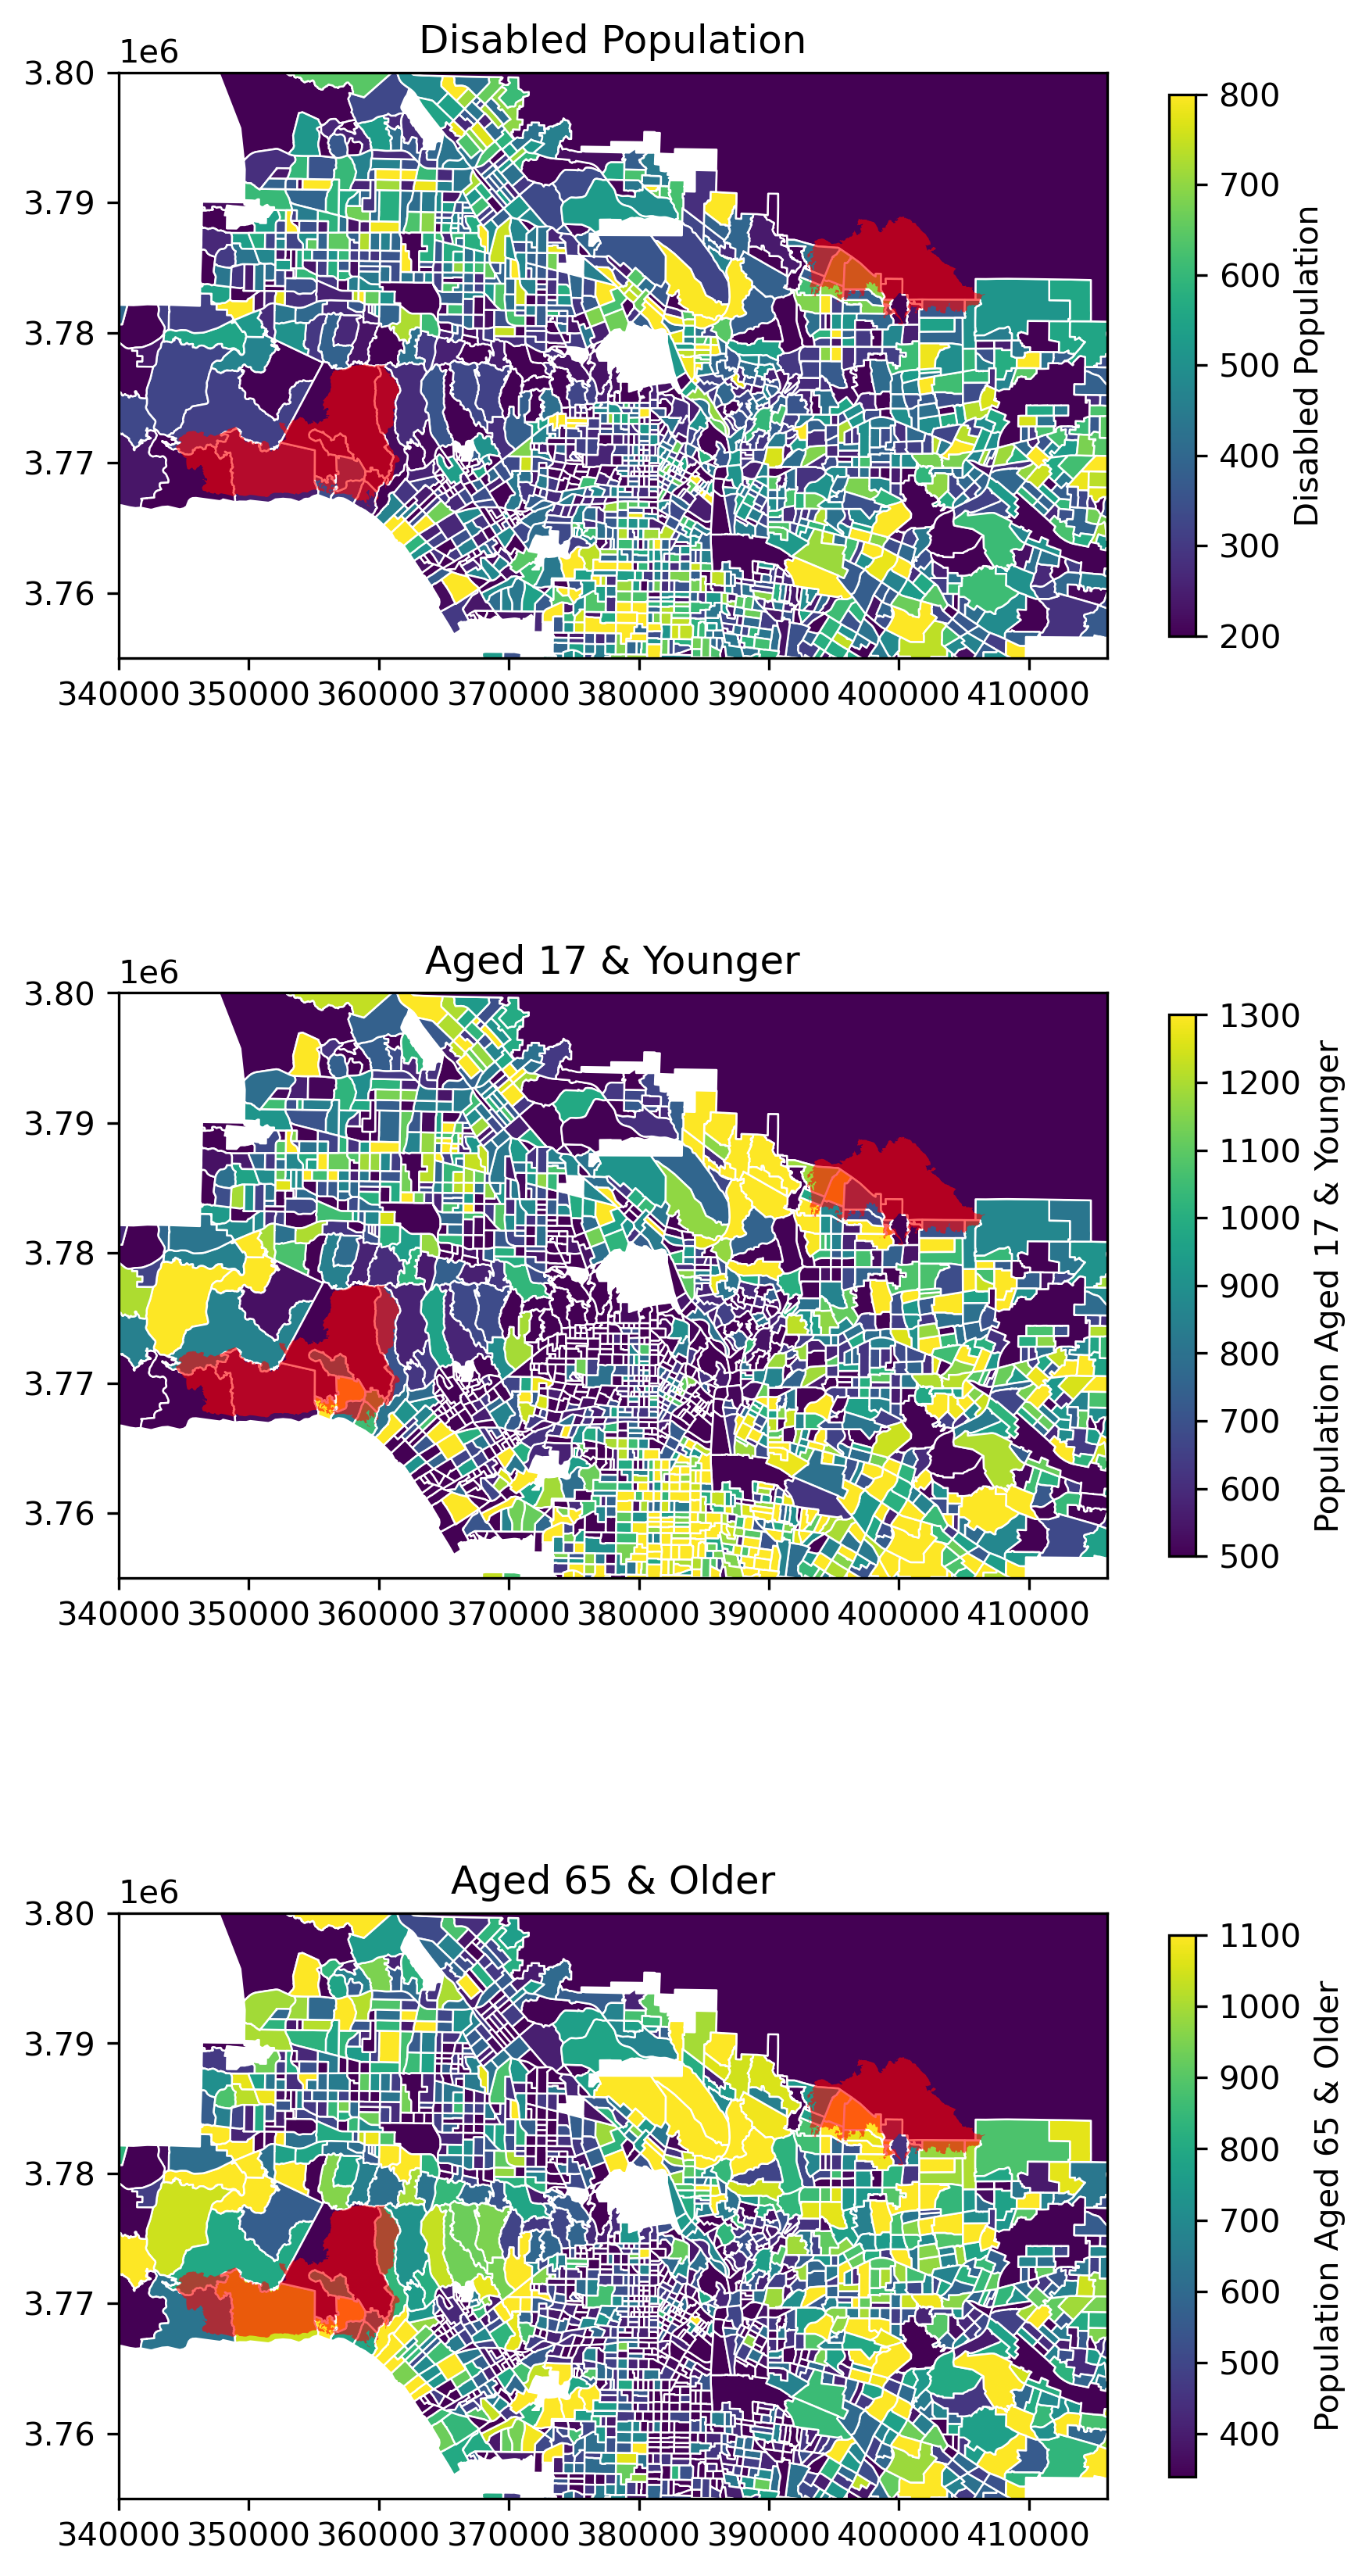

In [140]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(6, 12), dpi=300)

categories = ['E_DISABL', 'E_AGE17', 'E_AGE65']
titles = [
    'Disabled Population',
    'Aged 17 & Younger',
    'Aged 65 & Older',
]
colorbars = [
    'Disabled Population',
    'Population Aged 17 & Younger',
    'Population Aged 65 & Older'
]
vmin_vals = [200, 500, 340] 
vmax_vals = [800, 1300, 1100] 

for i, cat in enumerate(categories):
    merged_df.plot(column=cat, ax=axs[i], edgecolor='white', lw=0.6, facecolor='grey',
                   legend=True, cmap='viridis', vmin=vmin_vals[i], vmax=vmax_vals[i],
                   legend_kwds={'label': colorbars[i], 'shrink': 0.6})
    
    # Fire Perimeter Plot
    fire_perimeter_gdf.plot(ax=axs[i], facecolor='red', alpha=0.6)

    axs[i].set_xlim(340000, 416000)
    axs[i].set_ylim(3.755e6, 3.80e6)

    axs[i].set_title(titles[i], fontsize=12)

plt.tight_layout()
plt.show()


### Fire Spread & Vulnerability Themes 

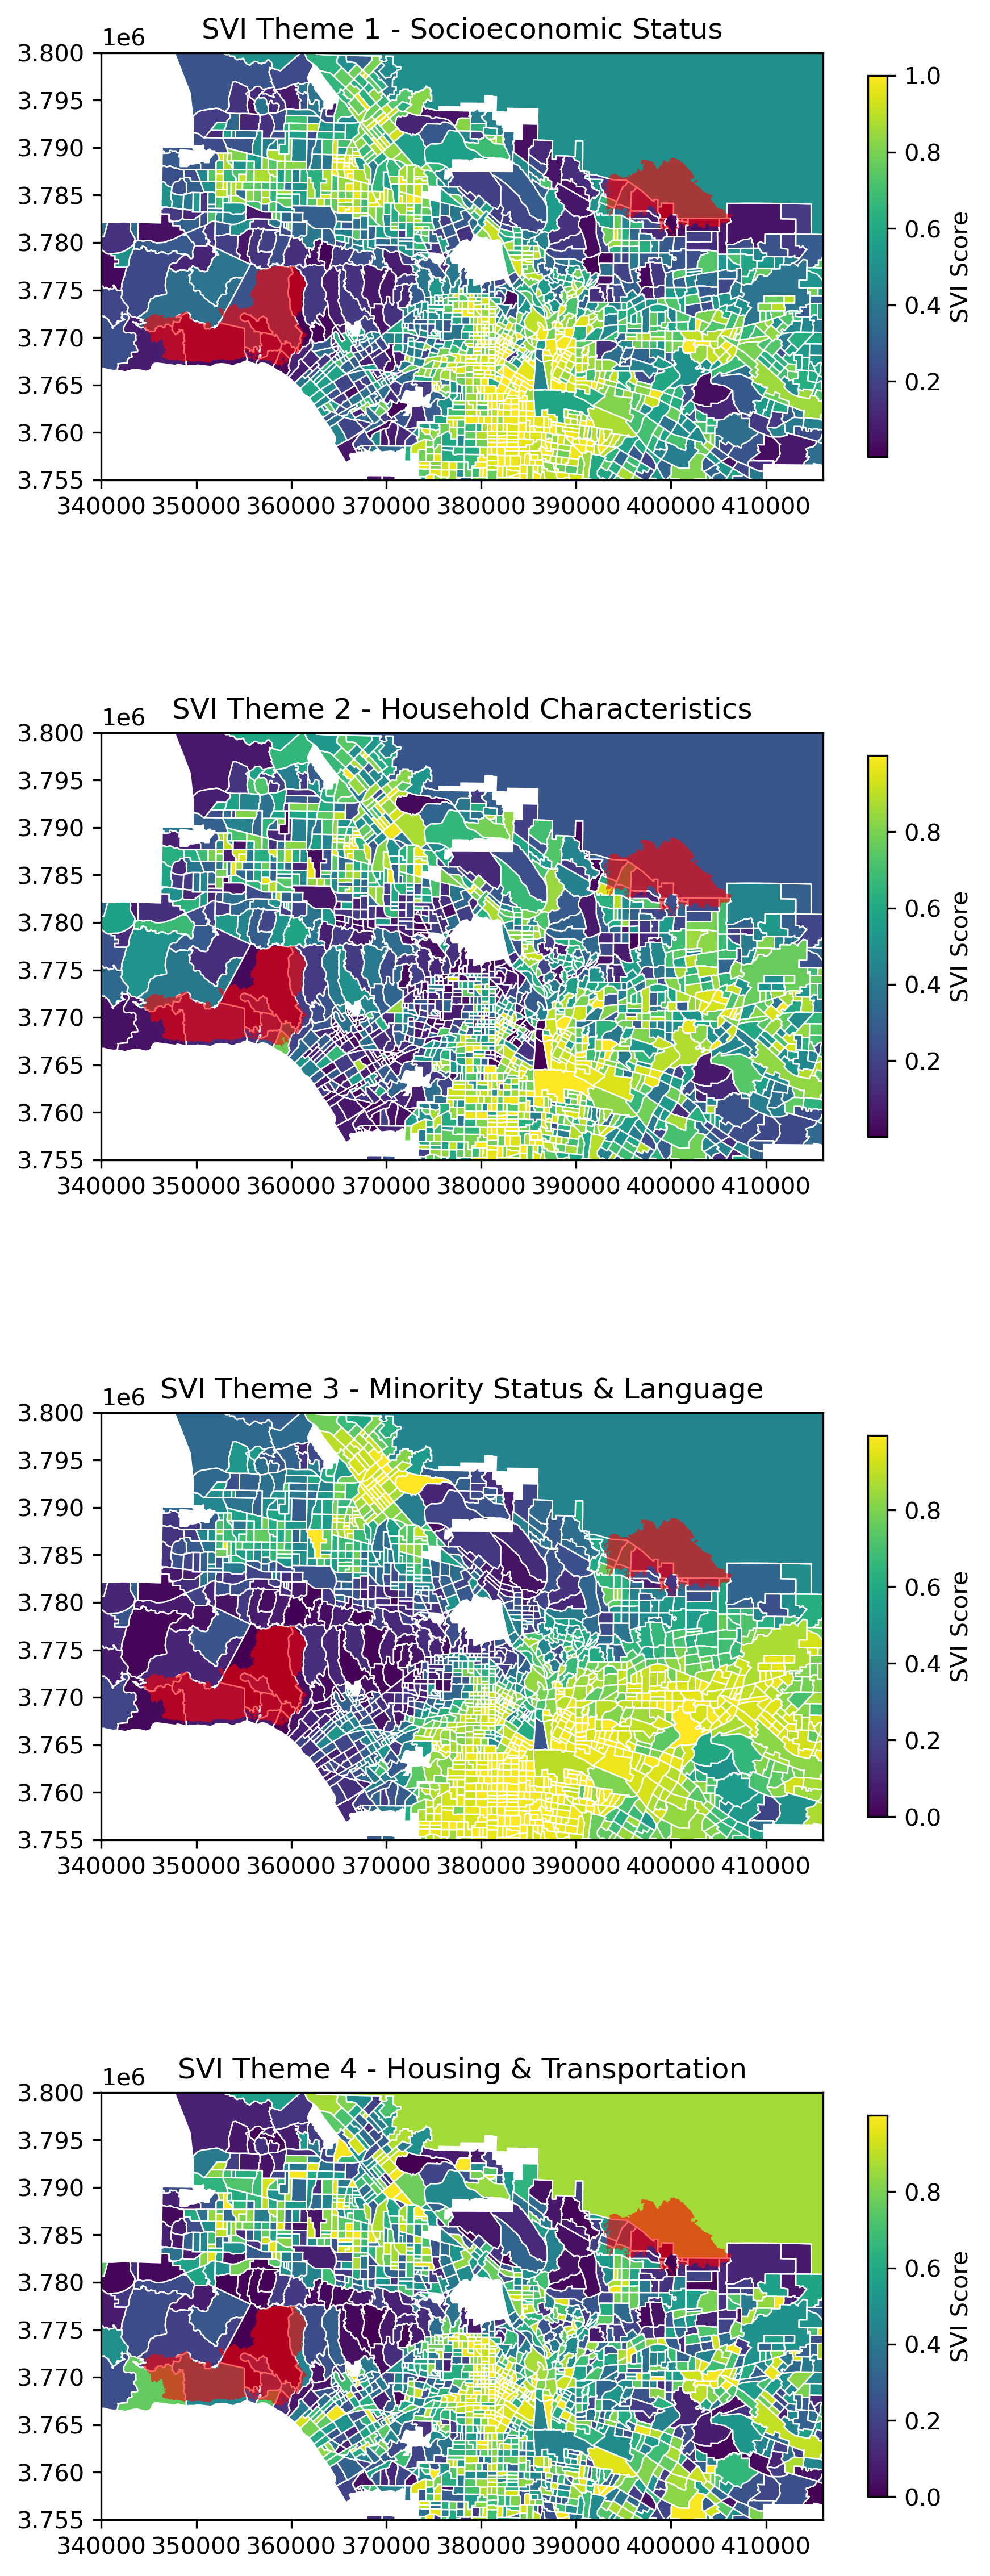

In [143]:
### ChatGPT helped with the loops 

fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(6, 16), dpi=300)

themes = ['RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4']
titles = [
    'SVI Theme 1 - Socioeconomic Status',
    'SVI Theme 2 - Household Characteristics',
    'SVI Theme 3 - Minority Status & Language',
    'SVI Theme 4 - Housing & Transportation'
]

for i, theme in enumerate(themes):

    merged_df.plot(column=theme, ax=axs[i], edgecolor='white', lw=0.6, facecolor='grey',
                   legend=True, legend_kwds={'label': 'SVI Score', 'shrink': 0.6})
    
    # Fire Perimeter Plot
    fire_perimeter_gdf.plot(ax=axs[i], facecolor='red', alpha=0.6)

    axs[i].set_xlim(340000, 416000)
    axs[i].set_ylim(3.755e6, 3.80e6)

    axs[i].set_title(titles[i], fontsize=12)

plt.tight_layout()
plt.show()


In [126]:
merged_df.describe()

FIPS    AREA_SQMI     E_DISABL      E_AGE17      E_AGE65  \
count  2.496000e+03  2467.000000  2467.000000  2467.000000  2467.000000   
mean   6.037403e+09     1.585942   423.250507   848.228618   573.797730   
std    2.306432e+05    15.238061   210.696864   433.178913   308.352989   
min    6.037101e+09     0.017727     0.000000     0.000000     0.000000   
25%    6.037209e+09     0.210112   272.000000   537.500000   348.000000   
50%    6.037403e+09     0.363446   393.000000   810.000000   515.000000   
75%    6.037552e+09     0.640747   543.000000  1115.500000   748.500000   
max    6.037990e+09   575.174927  1655.000000  3247.000000  2037.000000   

        RPL_THEME1   RPL_THEME2   RPL_THEME3   RPL_THEME4   RPL_THEMES  
count  2467.000000  2467.000000  2467.000000  2467.000000  2467.000000  
mean      0.596946     0.520611     0.628960     0.548976     0.583711  
std       0.282211     0.290183     0.292731     0.285062     0.289089  
min       0.002500     0.000300     0.000000     0.000000     0.001500  
25%       0.368850     0.274500     0.384700     0.311000     0.348850  
50%       0.635500     0.538900     0.700100     0.572500     0.634600  
75%       0.848400     0.780800     0.894000     0.798050     0.833200  
max       1.000000     0.999800     0.994700     0.999900     0.999800

In [219]:
## population (World_Pop) 

# could do a zonal stats (using fire perimater to see number of people affected) 

In [220]:
# how about number of people per tract 

# intersection of tract & fire perimeter 

# and then zonal_stats using that intersection (to find population affected) 

# can use this for Weighted Social Vulnerability Calculation 

In [227]:
## also check out land cover dataset (https://gee-community-catalog.org/projects/S2TSLULC/) :: 2023 lowest cloud cover 

# how many buildings were destroyed 
# how much forest area was burned 
# compare forest destruction to buildings 
# how to incorporate NDVI here... 


## can also use land cover (to do a BEFORE and after) : check changes to land cover 


In [228]:
## NDVI time series (Yogerej) 

In [229]:
## ERA 5 (spatial plot of temp values & high risk areas) 
# also look at time series to look at values (before, during & after) 
# what has been the trend over the past year/two : temperatures rising? 
# what were the wind speed & temperatures like same time, previous years? 

In [223]:
## spacing between houses 
## building materials 